In [1]:
import ipywidgets as widgets
import pandas as pd
from github import Github
import requests
from bs4 import BeautifulSoup
from copy import deepcopy as dcopy

import matplotlib.pyplot as plt
import numpy as np
import os

Output()

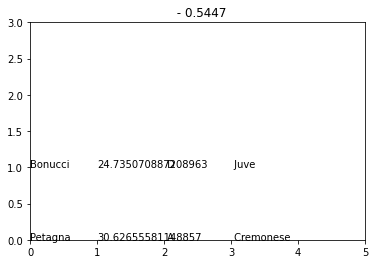

In [2]:
reset = True

check = widgets.Checkbox(
    value=False,
    description='Check me',
    disabled=False
)

user_field_shown = widgets.Text(
    value='',
    placeholder='username',
    description='User:',
    disabled=False
)


user_field_hidden = widgets.Text(
    value=' ',
    placeholder='username',
    description='User:',
    disabled=False
)
    

def show_players(check, user_field_hidden):

    response = requests.get("https://github.com/AstaFantacalcio/Asta-Fantacalcio/blob/main/2022_2023/data.csv")
    soup = BeautifulSoup(response.content, "html.parser")
    
    hash_last_commit = soup.find("a", {"class": "d-none js-permalink-shortcut"}).get("href").split("/")[-3]
    
    url_data = fr"https://raw.githubusercontent.com/AstaFantacalcio/Asta-Fantacalcio/{hash_last_commit}/2022_2023/data.csv"
    data_csv = pd.read_csv(url_data, header=None)
    
    fig = plt.figure()
    counter_row = 0
    for index, row in data_csv.iterrows():
        for counter, feat in enumerate(row):
            if counter == 1:
                plt.text(counter, counter_row, float(feat) + np.random.random())
            else:
                plt.text(counter, counter_row, feat)
        counter_row += 1

    plt.xlim(0, 5)
    plt.ylim(0, len(data_csv) + 1)
    plt.title(f"{user_field_hidden} - {np.random.random():.4f}")

    g = Github(os.environ['GITHUB_TOKEN'])
    GITHUB_REPO = 'Asta-Fantacalcio'

    repo = g.get_user().get_repo(GITHUB_REPO)
    git_file = os.path.join("2022_2023", f"data_{user_field_hidden}.csv")
    try:
        contents = repo.get_contents(git_file)
        repo.update_file(git_file, "committing files", "Uploaded!", contents.sha, branch="main")
    except:
        repo.create_file(git_file, "committing files", "Uploaded!", branch="main")
    
    reset = False
    
def on_button_clicked(_):
    reset = True
    
#     prev_user = dcopy(user_field_hidden.value)
    user_field_hidden.value = user_field_shown.value
#     next_user = dcopy(user_field_hidden.value)
#     if next_user == prev_user:
    check.value = not check.value

button = widgets.Button(description='Update player list')
button.on_click(on_button_clicked)

display(widgets.HBox([button, user_field_shown]))
widgets.interactive_output(show_players, {"check": check, "user_field_hidden": user_field_hidden})